#### Importing libraries

In [1]:
import re
import bs4
import requests
import spacy
import pandas as pd
nlp = spacy.load('en_core_web_sm')

from spacy import displacy
from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)

#### Read data

In [2]:
candidate_sentences = pd.read_csv("wiki_sentences_v2.csv")
candidate_sentences.shape

(4318, 1)

In [3]:
candidate_sentences['sentence'].sample(5) #random 5

2681                                                                              lin was announced to be directing the pilot.\n
3311                                                                             film applicators follow the astm standard d823.
911     an early special type of plastic film capacitors were the cellulose acetate film capacitors, also called mku capacitors.
51                                             the collectible tickets were offered in two sizes: standard  and godzilla-sized .
2556                                  the film's music was composed by michael stearns, lisa gerrard, and marcello de francisci.
Name: sentence, dtype: object

In [4]:
text = "the film had 200 patents"
doc = nlp(text)

for i in doc:
    print(i.text,"-->",i.dep_,"-->",i.pos_)

the --> det --> DET
film --> nsubj --> NOUN
had --> ROOT --> AUX
200 --> nummod --> NUM
patents --> dobj --> NOUN


In [5]:
# generalized

def get_entities(sent):
    ent1=''
    ent2=''
    prv_tok_dep = ""    # dependency tag of previous token in the sentence
    prv_tok_text = ""   # previous token in the sentence

    prefix = ""
    modifier = ""
    
    for tok in nlp(sent):
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " "+ tok.text
                    
            # check: token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " "+ tok.text
            
            if tok.dep_.find("subj") == True:
                ent1 = modifier +" "+ prefix + " "+ tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""      

            
            if tok.dep_.find("obj") == True:
                ent2 = modifier +" "+ prefix +" "+ tok.text
        
       
            # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
  #############################################################
    return [ent1.strip(), ent2.strip()]
      

In [6]:
get_entities("the sequel, blade runner 2049, was released on 6 october 2017.")

['sequel', '6 blade october']

In [7]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [8]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
    entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:28<00:00, 150.04it/s]


In [9]:
entity_pairs[10:30]

[['we', 'tests'],
 ['m global', 'international sales rights'],
 ['canadian musician robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['military  forces', 'arrest'],
 ['train', 'vuk'],
 ['', 'telepath selene gallio'],
 ['singer', 'sequel'],
 ['last  which', 'penn'],
 ['jessica chastain', 'same  character'],
 ['mauro fiore', 'cinematographer'],
 ['filming', 'october'],
 ['soundtrack', 'digitally  june'],
 ['album', 'digitally  august'],
 ['film', 'studios motion pictures'],
 ['it', '$  103.7'],
 ['', ''],
 ['it', 'executive producer yoshimitsu banno']]

#### Get the predicates

In [10]:
def get_relation(sent):
    
    doc = nlp(sent)

    # Matcher class object 
    matcher = Matcher(nlp.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'},
               {'DEP':'prep','OP':"?"},
               {'DEP':'agent','OP':"?"},  
               {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", None, pattern) 

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)

In [11]:
get_relation("John completed the task")

'completed'

In [12]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 4318/4318 [00:27<00:00, 155.43it/s]


In [13]:
pd.Series(relations).value_counts()[:50]

is               372
was              302
released on       88
are               74
include           72
were              67
released          42
's                39
composed by       35
became            31
have              31
has               30
become            28
released in       27
included          25
called            21
had               21
considered        20
made              20
been              19
produced          19
used              18
scheduled         17
be                16
written by        15
received          15
hired             14
wrote             14
stars             14
produced by       14
introduced in     13
went              13
wanted            12
directed by       12
won               11
began in          11
began             11
set               10
sold              10
gave              10
features          10
reported           9
said               9
produced in        9
shot in            9
cast as            9
used in            9
opened       

In [14]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [15]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

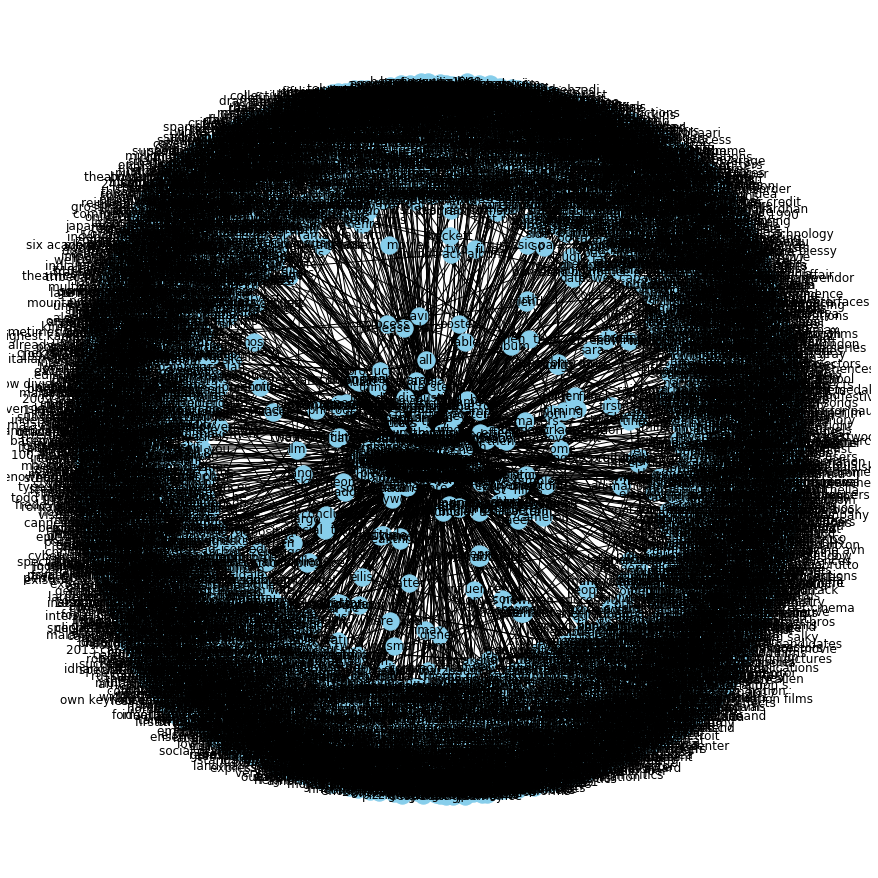

In [16]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

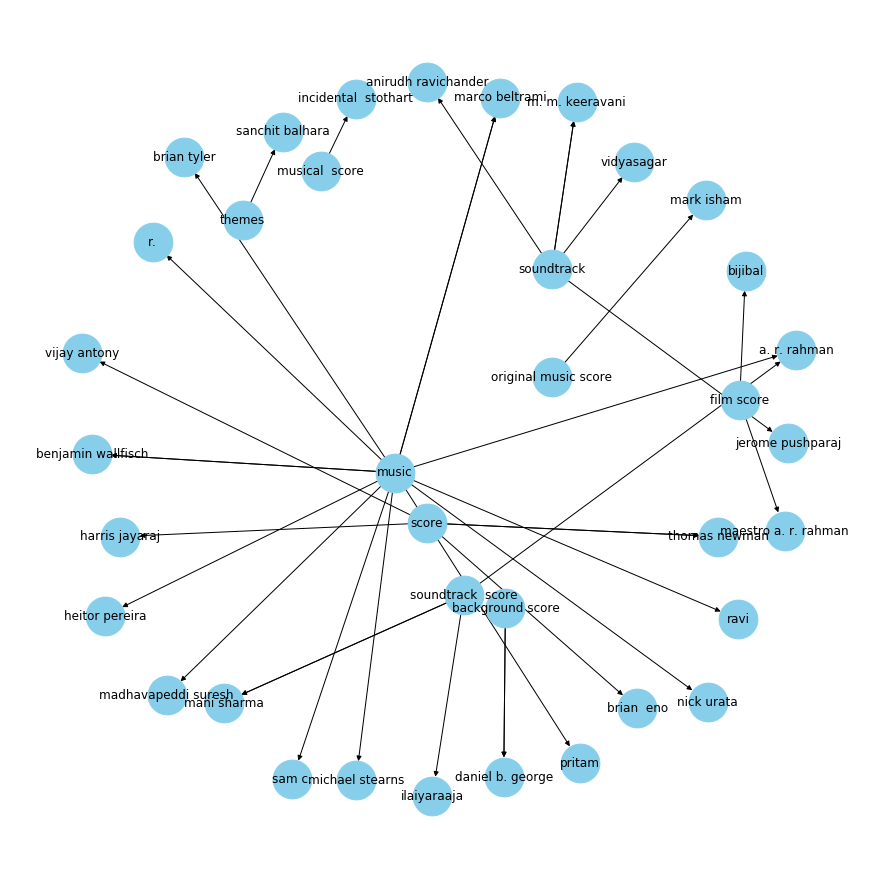

In [17]:
#less relations-composed by
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

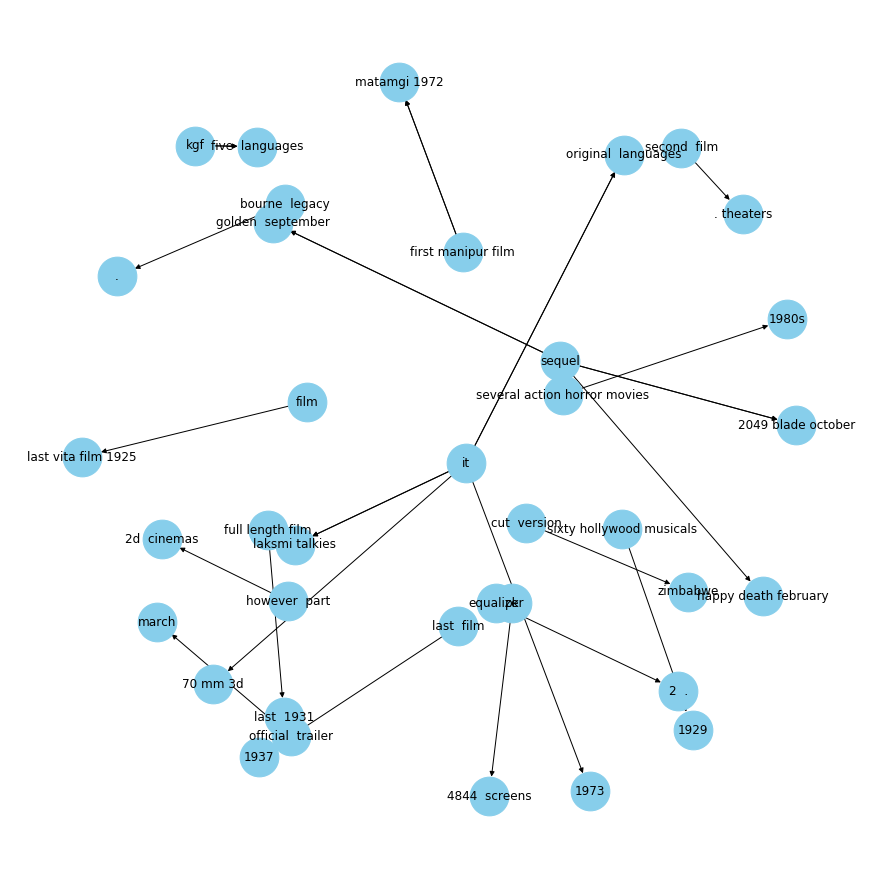

In [18]:
#less relations
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()